In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import pwlf
%load_ext autoreload
%autoreload 2

In [2]:
pump1_power_data =  pd.read_parquet("/home/alqua/Git/PumpStationMPC/data/static_models/raw_data_pump1_power.par").set_index("time").resample("1min").mean()
pump4_power_data =  pd.read_parquet("/home/alqua/Git/PumpStationMPC/data/static_models/raw_data_pump4_power.par").set_index("time").resample("1min").mean()
pump3_power_data =  pd.read_parquet("/home/alqua/Git/PumpStationMPC/data/static_models/raw_data_pump3_power.par").set_index("time").resample("1min").mean()
df = pd.read_parquet("../data/sym_data/sym_df_5m_res_with_co2.parquet")
df = df.join(pump1_power_data, on='time').join(pump4_power_data, on='time').join(pump3_power_data, on='time')
df = df.set_index("time")

In [3]:
import numpy as np
import pandas as pd

def filter_pump_to_fit(df, pump, bin_size):
    if pump == "pump1":
        xdf = df[(df["pump1_power"] > 0) & (df["pump3_power"] == 0) & (df["pump4_power"] == 0)]
    elif pump == "pump3":
        xdf = df[(df["pump3_power"] > 0) & (df["pump1_power"] == 0) & (df["pump4_power"] == 0)]
    elif pump == "pump4":
        xdf = df[(df["pump4_power"] > 0) & (df["pump1_power"] == 0) & (df["pump3_power"] == 0)]
        
    max_value = xdf['pump1_power'].max()
    bins = np.arange(0, max_value + bin_size, bin_size)
    labels = [f'{round(bins[i], 2)}-{round(bins[i + 1], 2)}' for i in range(len(bins) - 1)]
    
    xdf['pump1_power_bin'] = pd.cut(xdf['pump1_power'], bins=bins, labels=labels, include_lowest=True)
    mean_outflow_by_bin = xdf.groupby('pump1_power_bin')['outflow'].median().reset_index()
    
    mean_outflow_by_bin['bin_center'] = mean_outflow_by_bin['pump1_power_bin'].apply(
        lambda x: (bins[labels.index(x)] + bins[labels.index(x) + 1]) / 2 if pd.notnull(x) else np.nan
    )
    
    mean_outflow_by_bin = mean_outflow_by_bin.dropna()
    return xdf, mean_outflow_by_bin


In [4]:
pump1_dynamic_df, pump1_power_binned = filter_pump_to_fit(df, "pump1", 0.1)

/tmp/ipykernel_926/3771444139.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xdf['pump1_power_bin'] = pd.cut(xdf['pump1_power'], bins=bins, labels=labels, include_lowest=True)
/tmp/ipykernel_926/3771444139.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_outflow_by_bin = xdf.groupby('pump1_power_bin')['outflow'].median().reset_index()


In [5]:
def filter_pump_to_fit(xdf, pump, bin_size ):
    if pump == "pump1":
        xdf = df[(df["pump1_power"]>0) & (df["pump3_power"]==0) & (df["pump4_power"]==0)]
    elif pump == "pump3":
        xdf = df[(df["pump3_power"]>0) & (df["pump1_power"]==0) & (df["pump4_power"]==0)]
    elif pump == "pump4":
        xdf = df[(df["pump4_power"]>0) & (df["pump1_power"]==0) & (df["pump3_power"]==0)]
        
    max_value = xdf['pump1_power'].max()
    bins = np.arange(0, max_value + bin_size, bin_size)
    labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]    
    xdf['pump1_power_bin'] = pd.cut(xdf['pump1_power'], bins=bins, labels=labels, include_lowest=True)
    mean_outflow_by_bin = xdf.groupby('pump1_power_bin')['outflow'].median().reset_index()
    mean_outflow_by_bin['bin_center'] = mean_outflow_by_bin['pump1_power_bin'].apply(lambda x: (bins[labels.index(x)] + bins[labels.index(x) + 1]) / 2)
    mean_outflow_by_bin = mean_outflow_by_bin.dropna()
    return xdf, mean_outflow_by_bin
    

In [6]:
pump1_dynamic_df, pump1_power_binned = filter_pump_to_fit(df, "pump1", 1)

/tmp/ipykernel_926/598825120.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xdf['pump1_power_bin'] = pd.cut(xdf['pump1_power'], bins=bins, labels=labels, include_lowest=True)
/tmp/ipykernel_926/598825120.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_outflow_by_bin = xdf.groupby('pump1_power_bin')['outflow'].median().reset_index()


In [7]:
def fit_piecewise(df, breaks):
    pwlf = pwlf.PiecewiseLinFit(df["bin_center"], df["outflow"])
    pwlf.fit_with_breaks(breaks)
    

In [8]:
def fit_piecewise(df, breaks):
    pwlf_model = pwlf.PiecewiseLinFit(df["bin_center"], df["outflow"])
    pwlf_model.fit_with_breaks(breaks)
    slopes = pwlf_model.slopes
    intercepts = pwlf_model.intercepts
    breakpoints = pwlf_model.fit_breaks

    return pwlf_model, {
        "slopes": slopes,
        "intercepts": intercepts,
        "breakpoints": breakpoints
    }

In [9]:
missing_data = pd.DataFrame({
    'pump1_power_bin': ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4'],
    'outflow': [0.0, 0.0, 0.0, 0.0],  # Assuming outflow is 0 for these bins
    'bin_center': [0.05, 0.15, 0.25, 0.35]
})

# Concatenate the missing data with the existing dataframe
pump1_power_binned = pd.concat([missing_data, pump1_power_binned]).reset_index(drop=True)

In [10]:
#pump1_power_binned['outflow'] = pd.to_numeric(pump1_power_binned['outflow'], errors='coerce')
#pump1_power_binned['outflow'].iloc[:3] = 0

In [11]:
pump1_power_model, fit_params = fit_piecewise(pump1_power_binned, [0,30,80])

In [12]:
fit_params

{'slopes': array([ 4.82246804, 14.86423641]),
 'intercepts': array([ -18.62012472, -319.87317564]),
 'breakpoints': array([ 0, 30, 80])}

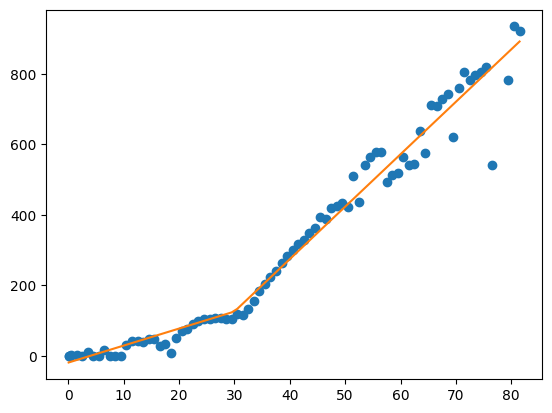

In [13]:
plt.plot(pump1_power_binned['bin_center'], pump1_power_binned['outflow'], 'o')
plt.plot(pump1_power_binned['bin_center'], pump1_power_model.predict(pump1_power_binned['bin_center']), '-')

In [14]:
pump1_dynamic_df["ypred"] = pump1_power_model.predict(pump1_dynamic_df["pump1_power"])
#pump1_dynamic_df = pump1_dynamic_df.reset_index()

/tmp/ipykernel_926/452312434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pump1_dynamic_df["ypred"] = pump1_power_model.predict(pump1_dynamic_df["pump1_power"])


In [15]:
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler
 
 
fig = FigureWidgetResampler(go.Figure())
fig.update_layout(margin=dict(l=10, r=10, t=10, b=10))
fig.add_trace(go.Scattergl(name=r'yhat', showlegend=True), hf_x=pump1_dynamic_df.index, hf_y=pump1_dynamic_df['ypred'])
fig.add_trace(go.Scattergl(name=r'Outflow', showlegend=True), hf_x=pump1_dynamic_df.index, hf_y=pump1_dynamic_df['outflow'])
fig.update_layout(height=400, template="plotly_dark")
display(fig)

/home/alqua/anaconda3/envs/mpc_env/lib/python3.11/site-packages/plotly_resampler/figure_resampler/utils.py:177: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/home/alqua/anaconda3/envs/mpc_env/lib/python3.11/site-packages/plotly_resampler/figure_resampler/utils.py:178: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> yhat <i style="color:#fc9944">~2h</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '2f2ae42f-7892-432d-98b2-36b166814415',
              'x': array([datetime.datetime(2023, 5, 23, 0, 0, tzinfo=<UTC>),
                          datetime.datetime(2023, 5, 23, 0, 38, tzinfo=<UTC>),
                          datetime.datetime(2023, 5, 23, 1, 11, tzinfo=<UTC>), ...,
                          datetime.datetime(2023, 8, 3, 16, 19, tzinfo=<UTC>),
                          datetime.datetime(2023, 8, 3, 17, 5, tzinfo=<UTC>),
                          datetime.datetime(2023, 8, 3, 17, 59, tzinfo=<UTC>)], dtype=object),
              'y': array([155.18782099, 230.07879809, 118.03254511, ..., 396.85553456,
                          260.99640963, 257.75104889])},
             {'name': '<b style="color:sandybrown">[R]</b> Outflow <i style="color:#fc9944">~2h</i>',
        

In [16]:
pump1_dynamic_df["residual"] = pump1_dynamic_df["outflow"] - pump1_dynamic_df["ypred"]

/tmp/ipykernel_926/1430061287.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



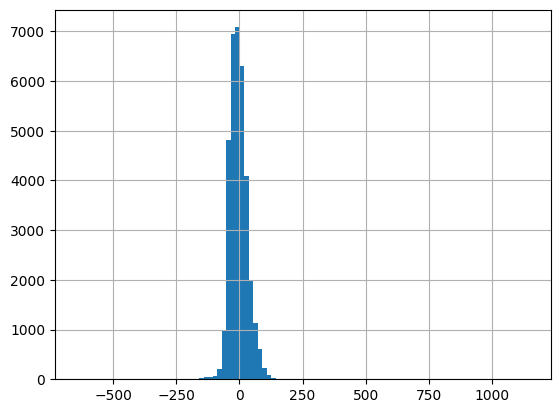

In [17]:
_ = plt.hist(pump1_dynamic_df["residual"], bins=100)
plt.grid()

In [18]:
np.mean(pump1_dynamic_df["residual"])

-3.3192000201076333